In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
df = pd.read_csv("potential.csv")
plt.tricontourf(df.x, df.y, df.potential, levels=50)
plt.colorbar(label="Potential")
plt.axis("equal")
plt.show()


NameError: name 'pd' is not defined

(300, 8)
(300,)


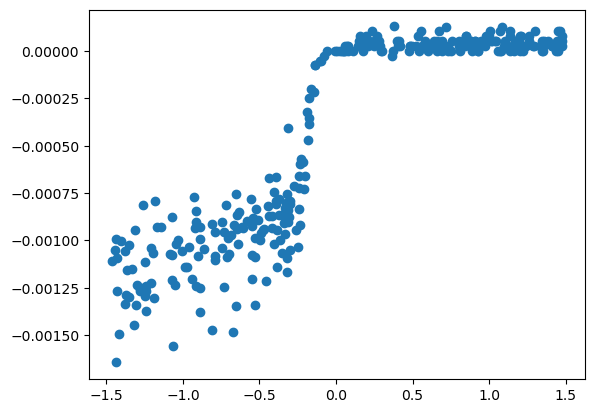

In [3]:
batch = np.load("currentData/batch_test.npz")
print(batch["inputs"].shape)
print(batch["outputs"].shape)

plt.scatter(batch["inputs"][:,1], batch["outputs"])

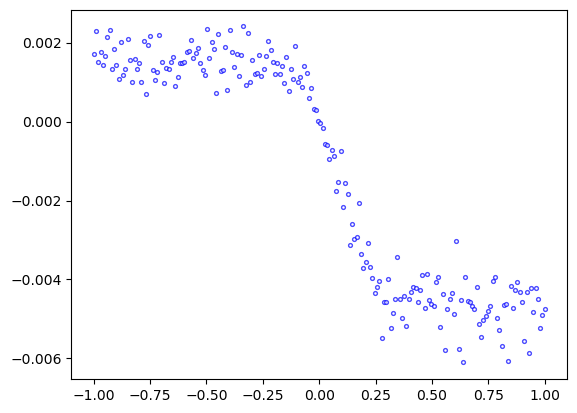

In [8]:
data = np.load("currents_saved.npz")
currents = data["currents"]

voltages = np.linspace(-1., 1., currents.shape[0])

plt.scatter(voltages, currents, s=7.5, edgecolors="blue", facecolor="w", alpha=.7)

(20, 7)
(20, 1)


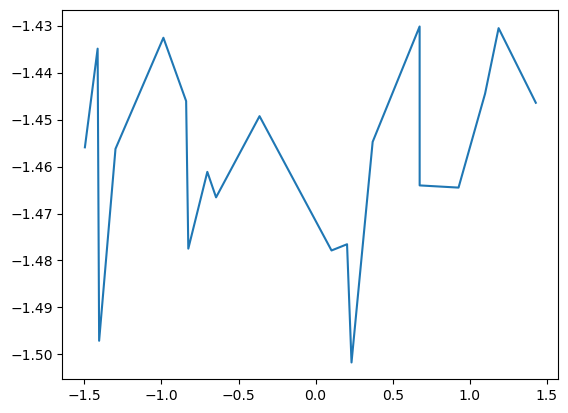

In [24]:
batch = np.load("currentData/batch1.npz")

print(batch["inputs"].shape)
print(batch["outputs"].shape)

plt.plot(np.sort(batch["inputs"][:,5]), batch["outputs"])